In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline(aug_train, lags_dict, rolling_windows)
aug_test_processed, _           = full_preprocessing_pipeline(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]
X_train_aug = aug_train_processed[features]
y_train_aug = aug_train_processed[target]

y_test  =org_test_processed[target]
X_test  =org_test_processed[features]

In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

In [25]:
# ------------------ Multivariate N-BEATS Model ------------------

class NBeatsBlock(nn.Module):
    def __init__(self, input_size, forecast_size, hidden_size=128, num_layers=4):
        super().__init__()
        self.fc = nn.Sequential(*[
            nn.Linear(input_size if i==0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        self.backcast = nn.Linear(hidden_size, input_size)
        self.forecast = nn.Linear(hidden_size, forecast_size)

    def forward(self, x):
        x = self.fc(x)
        return self.backcast(x), self.forecast(x)

class NBeats(nn.Module):
    def __init__(self, input_size, forecast_size, n_blocks=3, hidden_size=128, num_layers=4):
        super().__init__()
        self.input_size = input_size
        self.forecast_size = forecast_size  # <-- FIX: assign forecast_size
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, forecast_size, hidden_size, num_layers)
            for _ in range(n_blocks)
        ])

    def forward(self, x):
        residual = x
        forecast_total = torch.zeros(x.size(0), self.forecast_size).to(x.device)  # <-- USE self.forecast_size
        for block in self.blocks:
            backcast, forecast = block(residual)
            residual = residual - backcast
            forecast_total += forecast
        return forecast_total


In [28]:
# ------------------ Sequence Preparation ------------------
def create_multivariate_sequences(X_data, y_data, input_len, forecast_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - input_len - forecast_len + 1):
        X_seq.append(X_data[i:i+input_len].flatten())  # flatten multivariate input
        y_seq.append(y_data[i+input_len:i+input_len+forecast_len])
    return np.array(X_seq), np.array(y_seq)

# ------------------ Desequencing Function ------------------
def desequence_nbeats(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start_idx = i + input_len
        end_idx = start_idx + forecast_len
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast


In [22]:
# ------------------ Training Function ------------------
def train_nbeats_multivariate(X_train, y_train, input_len, forecast_len, epochs=10, batch_size=32):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

    num_features = X_train.shape[1]

    X_seq, y_seq = create_multivariate_sequences(X_train_scaled, y_train_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)

    model = NBeats(input_size=input_len * num_features, forecast_size=forecast_len)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss/len(dataloader):.4f}")

    return model, scaler_X, scaler_y


In [31]:
def evaluate_nbeats_multivariate(model, scaler_X, scaler_y, X_test, y_test, input_len, forecast_len, time_index=None, start_point=0, end_point=None):
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    num_features = X_test.shape[1]
    X_seq, y_seq = create_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_tensor).numpy()

    # Inverse scaling
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1,1)).reshape(preds_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1,1)).reshape(y_seq.shape)

    # Desequencing
    merged_pred = desequence_nbeats(preds, input_len, forecast_len)
    merged_true = desequence_nbeats(y_true, input_len, forecast_len)

    merged_pred = merged_pred[start_point:end_point]
    merged_true = merged_true[start_point:end_point]

    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    if time_index is not None:
        valid_timestamps = time_index[-len(merged_true):]
        plot_range = valid_timestamps
    else:
        plot_range = range(len(merged_true))

    if end_point is None: end_point = len(plot_range)

    plt.figure(figsize=(16,6))
    plt.plot(plot_range, merged_true, label="Actual", color="black")
    plt.plot(plot_range, merged_pred, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("Multivariate N-BEATS Forecast vs Actual (Desequenced)")
    plt.legend()
    plt.grid(True)
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


In [14]:
# ------------------ Model Saving/Loading ------------------
def save_model(model, scaler_X, scaler_y, model_path):
    torch.save(model.state_dict(), model_path + '_nbeats.pth')
    joblib.dump(scaler_X, model_path + '_scalerX.pkl')
    joblib.dump(scaler_y, model_path + '_scalerY.pkl')


def load_model(model_path, input_len, forecast_len, n_features):
    model = NBeats(input_len, forecast_len, n_features)
    model.load_state_dict(torch.load(model_path + '_nbeats.pth'))
    scaler_X = joblib.load(model_path + '_scalerX.pkl')
    scaler_y = joblib.load(model_path + '_scalerY.pkl')
    return model, scaler_X, scaler_y

In [15]:
X_train_org = org_train_processed[features].values
y_train_org = org_train_processed[target].values
X_test = org_test_processed[features].values
y_test = org_test_processed[target].values

input_len = 24
forecast_len = 12

In [26]:
print("Training Multivariate N-BEATS...")
model_nbeats_multi, scaler_X_multi, scaler_y_multi = train_nbeats_multivariate(X_train_org, y_train_org, input_len, forecast_len, epochs=10)

Training Multivariate N-BEATS...


Epoch 1: 100%|██████████| 4377/4377 [00:36<00:00, 121.09it/s]


Epoch 1 Loss: 0.4051


Epoch 2: 100%|██████████| 4377/4377 [00:28<00:00, 151.84it/s]


Epoch 2 Loss: 0.3609


Epoch 3: 100%|██████████| 4377/4377 [00:30<00:00, 145.64it/s]


Epoch 3 Loss: 0.3494


Epoch 4: 100%|██████████| 4377/4377 [00:29<00:00, 145.93it/s]


Epoch 4 Loss: 12946.9498


Epoch 5: 100%|██████████| 4377/4377 [00:29<00:00, 148.12it/s]


Epoch 5 Loss: 2.5892


Epoch 6: 100%|██████████| 4377/4377 [00:29<00:00, 149.99it/s]


Epoch 6 Loss: 0.8384


Epoch 7: 100%|██████████| 4377/4377 [00:30<00:00, 145.68it/s]


Epoch 7 Loss: 0.4633


Epoch 8: 100%|██████████| 4377/4377 [00:30<00:00, 143.31it/s]


Epoch 8 Loss: 0.3753


Epoch 9: 100%|██████████| 4377/4377 [00:30<00:00, 144.60it/s]


Epoch 9 Loss: 0.3493


Epoch 10: 100%|██████████| 4377/4377 [00:30<00:00, 145.76it/s]


Epoch 10 Loss: 0.3460



Evaluating Multivariate N-BEATS...
Test MSE: 0.0267, MAE: 0.1328, RMSE: 0.1634


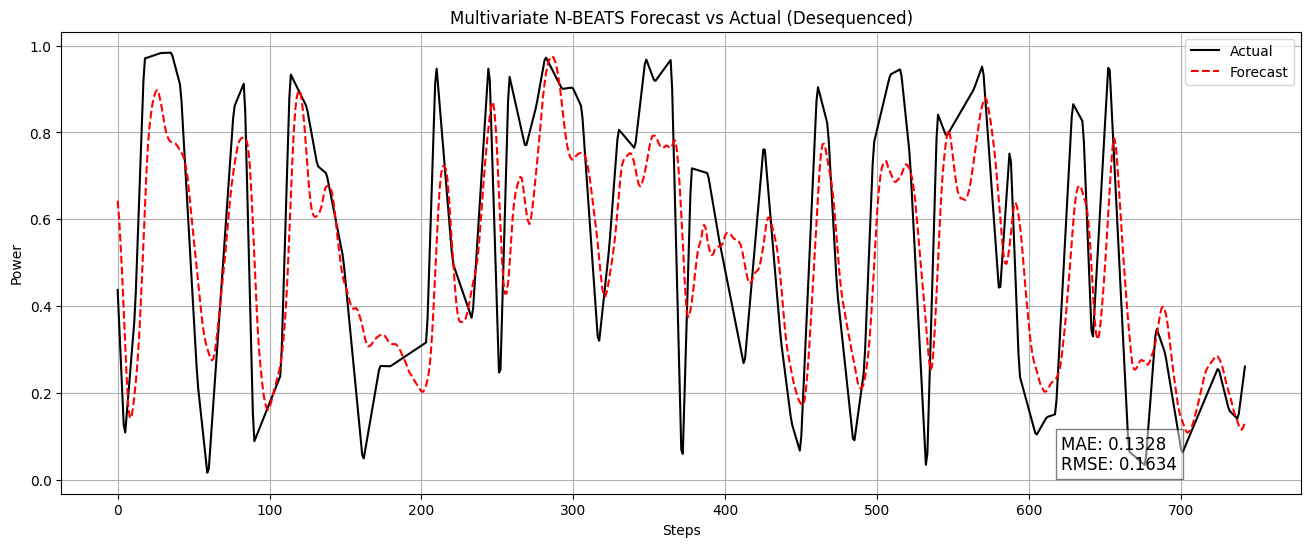

Test MSE: 0.0155, MAE: 0.1016, RMSE: 0.1245


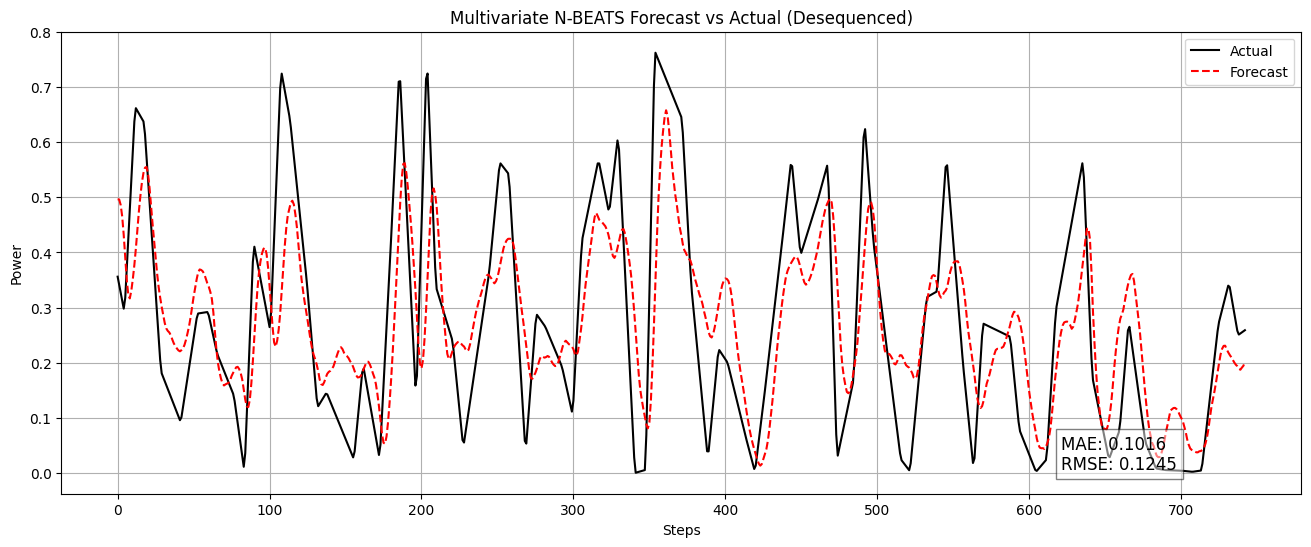

Test MSE: 0.0345, MAE: 0.1522, RMSE: 0.1856


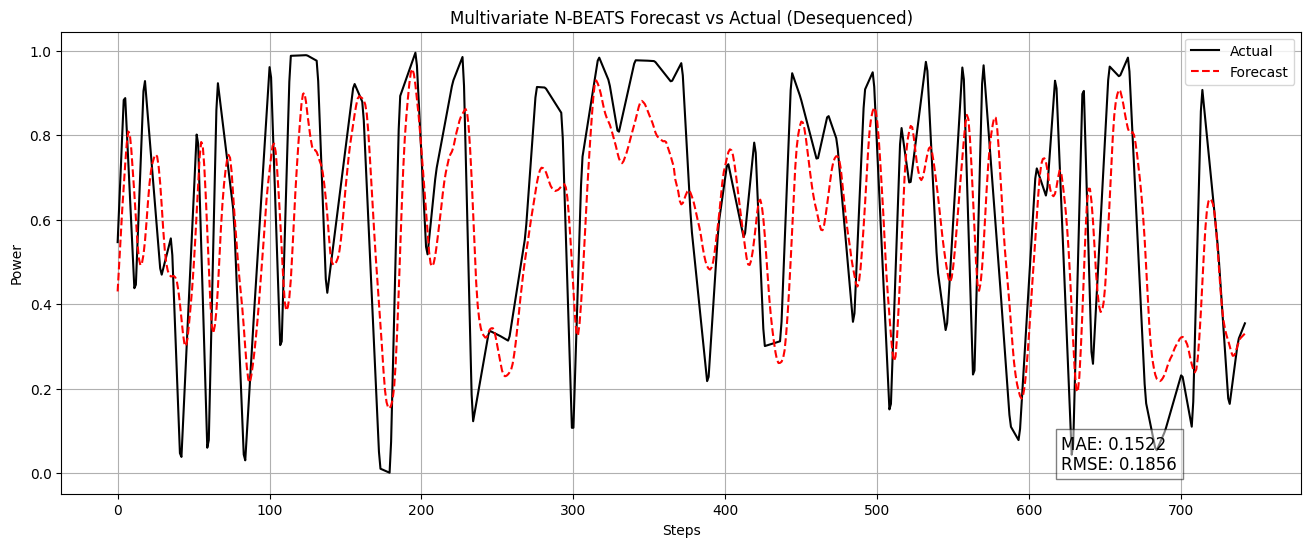

Test MSE: 0.0244, MAE: 0.1260, RMSE: 0.1562


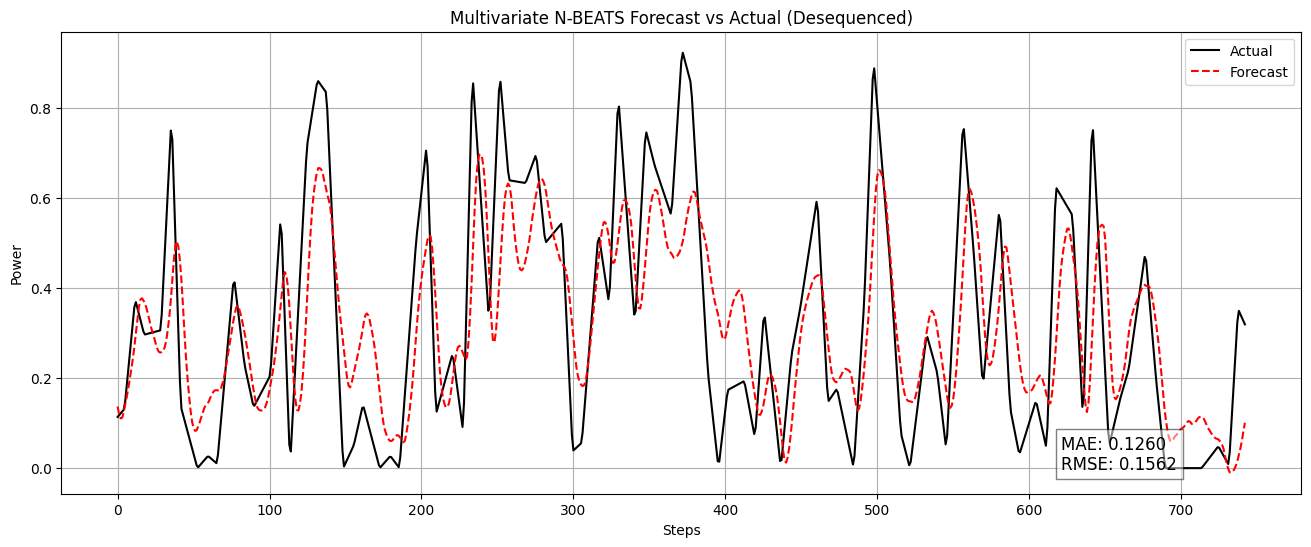

In [32]:

print("\nEvaluating Multivariate N-BEATS...")
evaluate_nbeats_multivariate(model_nbeats_multi, scaler_X_multi, scaler_y_multi, X_test, y_test, input_len, forecast_len, start_point=7991, end_point=8734)
evaluate_nbeats_multivariate(model_nbeats_multi, scaler_X_multi, scaler_y_multi, X_test, y_test, input_len, forecast_len, start_point=16726, end_point=17469)
evaluate_nbeats_multivariate(model_nbeats_multi, scaler_X_multi, scaler_y_multi, X_test, y_test, input_len, forecast_len, start_point=25461, end_point=26204)
evaluate_nbeats_multivariate(model_nbeats_multi, scaler_X_multi, scaler_y_multi, X_test, y_test, input_len, forecast_len, start_point=34196, end_point=34939)